In [16]:
import pandas as pd

# Cargar los archivos de datos
X_t0_path = 'Datos/competition_files/X_t0.parquet'
y_t0_path = 'Datos/competition_files/y_t0.parquet'

X_t0 = pd.read_parquet(X_t0_path)
y_t0 = pd.read_parquet(y_t0_path)

# Mostrar las primeras filas de los datasets
print(X_t0.head())
print(y_t0.head())

   borrow_block_number  borrow_timestamp  \
0              7711117      1.557197e+09   
1              7711123      1.557197e+09   
2              7711126      1.557197e+09   
3              7711672      1.557205e+09   
4              7712572      1.557217e+09   

                               wallet_address  first_tx_timestamp  \
0  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
1  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
2  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
3  0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6        1.557191e+09   
4  0xbd9ed130a53cfafcf81502e4d35329a6c4d53410        1.557217e+09   

   last_tx_timestamp  wallet_age  incoming_tx_count  outgoing_tx_count  \
0       1.557197e+09  19973049.0                199                438   
1       1.557197e+09  19973188.0                200                439   
2       1.557197e+09  19973238.0                201                440   
3       1.557198e+09    

In [17]:
# Agregar la variable target a X_t0
df = X_t0.copy()
df['target'] = y_t0

# Ver las primeras filas con la variable target
print(df.head())


   borrow_block_number  borrow_timestamp  \
0              7711117      1.557197e+09   
1              7711123      1.557197e+09   
2              7711126      1.557197e+09   
3              7711672      1.557205e+09   
4              7712572      1.557217e+09   

                               wallet_address  first_tx_timestamp  \
0  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
1  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
2  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
3  0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6        1.557191e+09   
4  0xbd9ed130a53cfafcf81502e4d35329a6c4d53410        1.557217e+09   

   last_tx_timestamp  wallet_age  incoming_tx_count  outgoing_tx_count  \
0       1.557197e+09  19973049.0                199                438   
1       1.557197e+09  19973188.0                200                439   
2       1.557197e+09  19973238.0                201                440   
3       1.557198e+09    

C:\Users\vicen\AppData\Local\Temp\ipykernel_2584\1583526327.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='Set1')


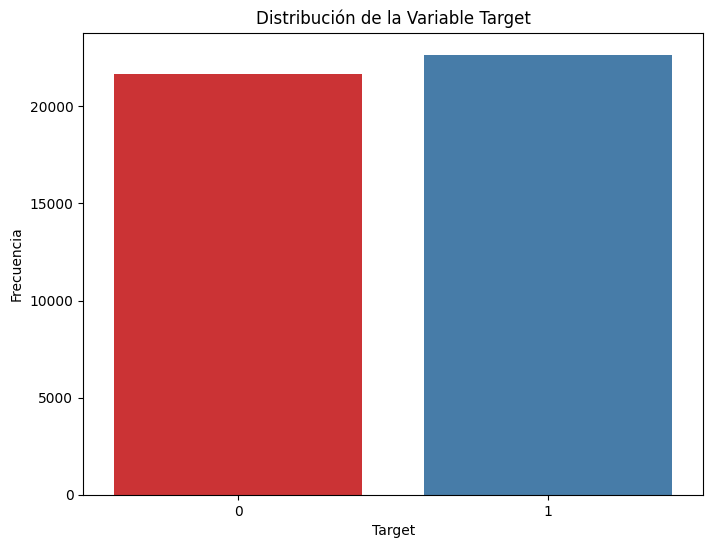

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico de barras para la distribución de la variable target
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df, palette='Set1')
plt.title('Distribución de la Variable Target')
plt.xlabel('Target')
plt.ylabel('Frecuencia')
plt.show()

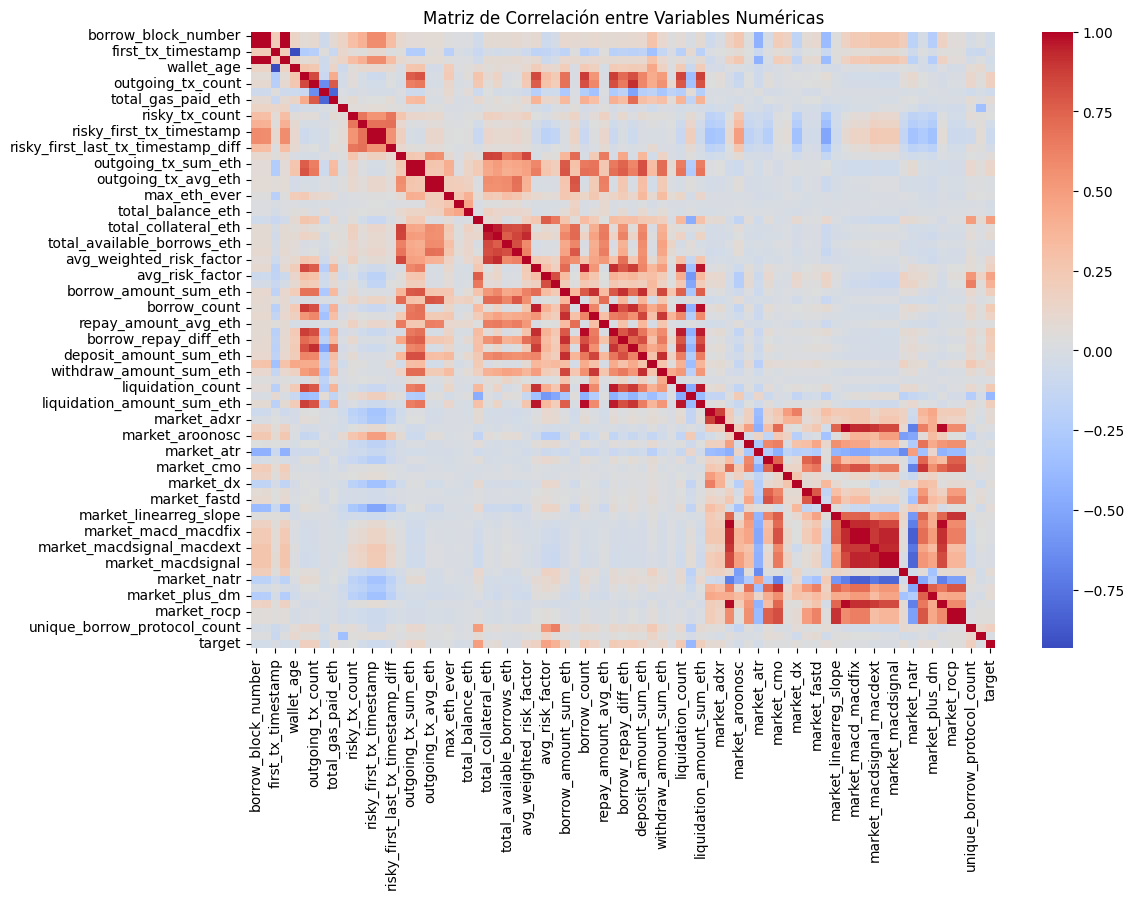

In [ ]:
# Excluir la columna 'wallet_address' para calcular la matriz de correlación
correlation_matrix = df.drop(columns=['wallet_address']).corr()

# Gráfico de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

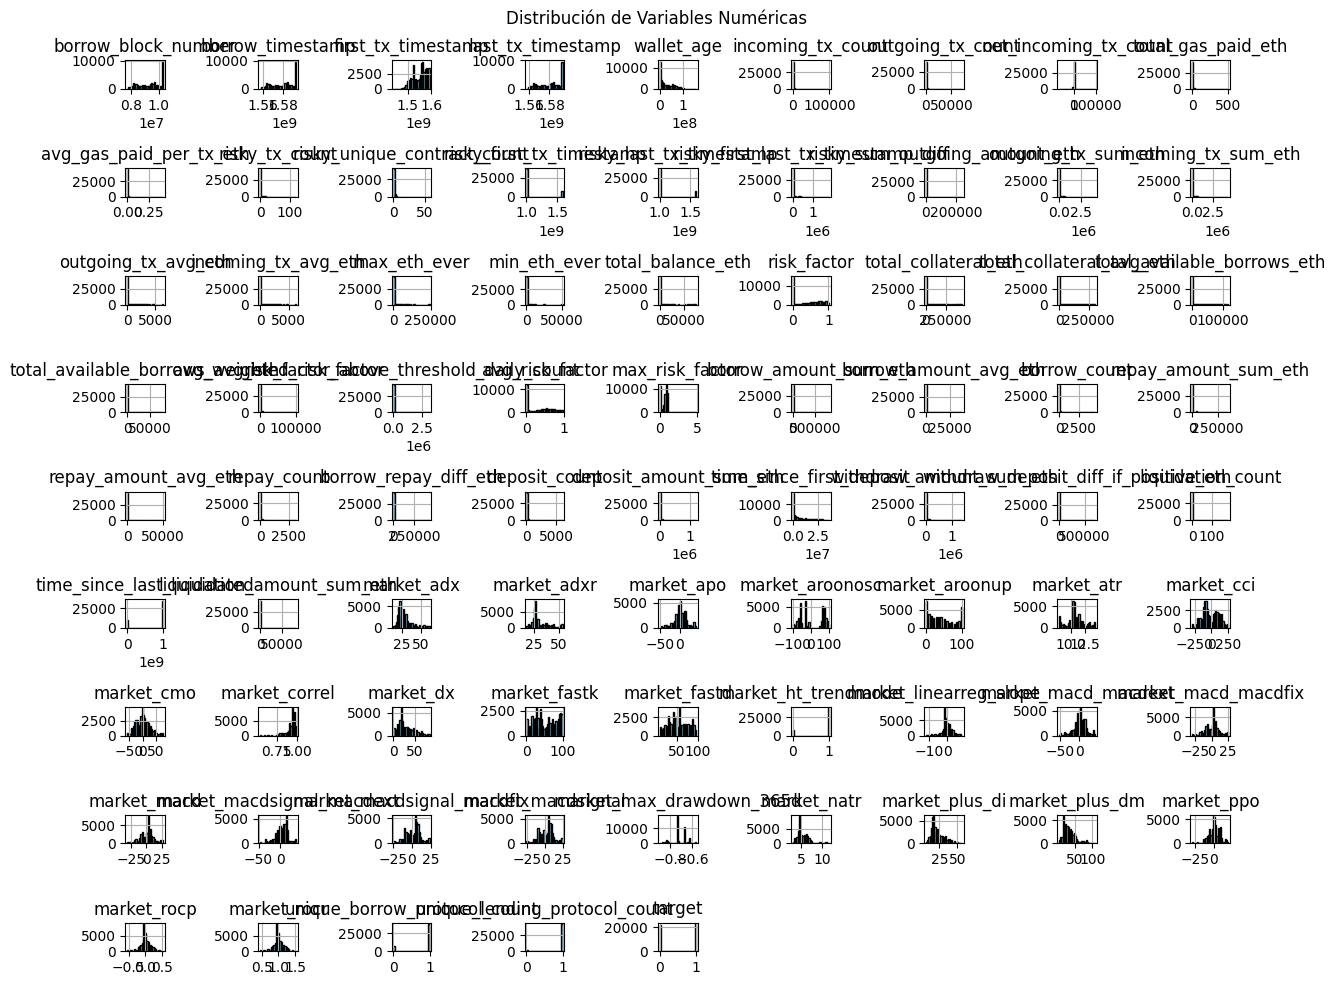

In [ ]:
# Seleccionar solo las variables numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Graficar histogramas para cada variable numérica
df[numeric_columns].hist(bins=30, figsize=(12, 10), color='skyblue', edgecolor='black')
plt.suptitle('Distribución de Variables Numéricas')
plt.tight_layout()
plt.show()

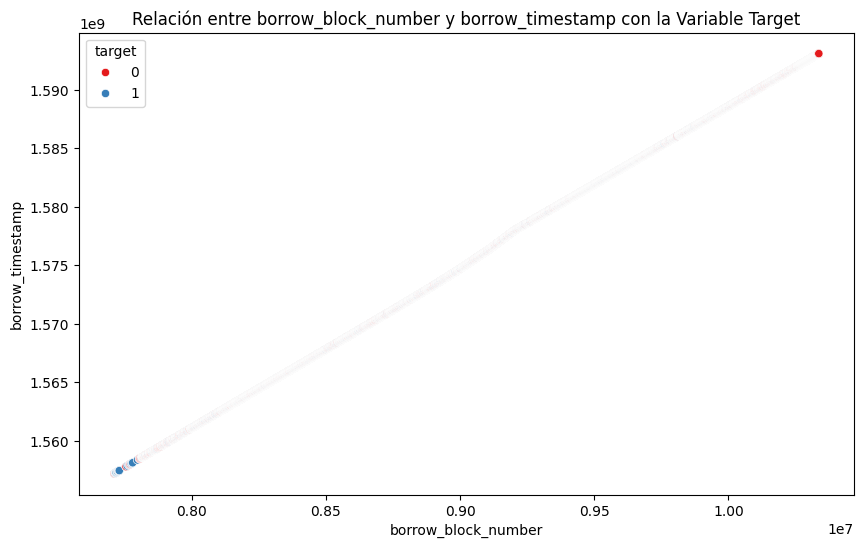

In [ ]:
# Graficar la relación entre las primeras dos variables numéricas y la variable target
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df[numeric_columns[0]], y=df[numeric_columns[1]], hue='target', data=df, palette='Set1')
plt.title(f'Relación entre {numeric_columns[0]} y {numeric_columns[1]} con la Variable Target')
plt.xlabel(numeric_columns[0])
plt.ylabel(numeric_columns[1])
plt.show()

C:\Users\vicen\AppData\Local\Temp\ipykernel_2584\239605734.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y=numeric_columns[0], data=df, palette='Set1')


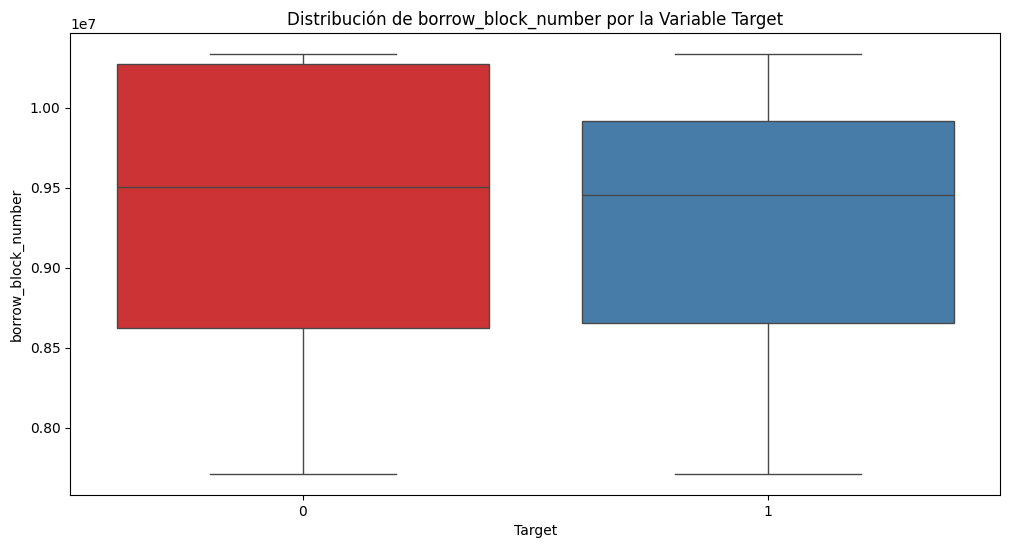

In [22]:
# Boxplot para las primeras variables numéricas
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y=numeric_columns[0], data=df, palette='Set1')
plt.title(f'Distribución de {numeric_columns[0]} por la Variable Target')
plt.xlabel('Target')
plt.ylabel(numeric_columns[0])
plt.show()

In [12]:
import pandas as pd

# Cargar el archivo Excel
file_path = 'Datos\competition_files\X_t0.parquet'
df = pd.read_parquet(file_path)

# Análisis descriptivo inicial
def describe_data(df):
    print("Resumen del dataframe:")
    print(df.info())
    print("\nEstadísticas descriptivas:\n")
    print(df.describe(include='all').transpose())

    print("\nValores únicos por columna:\n")
    unique_counts = df.nunique()
    print(unique_counts)

    print("\nPorcentaje de valores nulos por columna:\n")
    null_percentage = df.isnull().mean() * 100
    print(null_percentage)

    print("\nColumnas con alta varianza:\n")
    varianza = df.var(numeric_only=True)
    high_variance = varianza[varianza > varianza.mean()]
    print(high_variance)

    print("\nColumnas con pocos valores únicos:\n")
    low_unique = unique_counts[unique_counts <= 5]
    print(low_unique)

    return unique_counts, null_percentage, high_variance, low_unique

# Identificar columnas potencialmente problemáticas
def identify_columns_to_remove(unique_counts, null_percentage, high_variance, low_unique):
    columns_to_remove = []

    # Columnas con más del 50% de valores nulos
    null_threshold = 50
    columns_to_remove += list(null_percentage[null_percentage > null_threshold].index)

    # Columnas con un único valor
    columns_to_remove += list(unique_counts[unique_counts <= 1].index)

    # Columnas categóricas con baja diversidad
    columns_to_remove += list(low_unique.index)

    # Eliminar duplicados en la lista
    columns_to_remove = list(set(columns_to_remove))

    return columns_to_remove

# Ejecución
def main():
    print("Analizando el dataset...\n")
    unique_counts, null_percentage, high_variance, low_unique = describe_data(df)

    print("\nIdentificando columnas a eliminar...\n")
    columns_to_remove = identify_columns_to_remove(unique_counts, null_percentage, high_variance, low_unique)
    
    print(f"Columnas sugeridas para eliminar ({len(columns_to_remove)}):")
    print(columns_to_remove)

if __name__ == "__main__":
    main()

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\vicen\AppData\Local\Temp\ipykernel_2584\4168299249.py:4: SyntaxWarning: invalid escape sequence '\c'
  file_path = 'Datos\competition_files\X_t0.parquet'


Analizando el dataset...

Resumen del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 77 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   borrow_block_number                      44296 non-null  int64  
 1   borrow_timestamp                         44296 non-null  float64
 2   wallet_address                           44296 non-null  object 
 3   first_tx_timestamp                       44296 non-null  float64
 4   last_tx_timestamp                        44296 non-null  float64
 5   wallet_age                               44296 non-null  float64
 6   incoming_tx_count                        44296 non-null  int64  
 7   outgoing_tx_count                        44296 non-null  int64  
 8   net_incoming_tx_count                    44296 non-null  int64  
 9   total_gas_paid_eth                       44296 non-null  float64
 1

In [2]:
# Eliminar columnas relacionadas con "market" e identificadores irrelevantes
def clean_data(df):
    # Identificar columnas relacionadas con "market" y eliminar
    market_cols = [col for col in df.columns if "market" in col]
    identifier_cols = ["wallet_address", "borrow_block_number", "borrow_timestamp"]
    columns_to_drop = market_cols + identifier_cols
    df_cleaned = df.drop(columns=columns_to_drop, errors="ignore")
    
    print(f"Columnas eliminadas ({len(columns_to_drop)}): {columns_to_drop}")
    
    # Transformar columnas temporales en días
    temporal_cols = [col for col in df_cleaned.columns if "timestamp" in col]
    for col in temporal_cols:
        df_cleaned[col + "_days"] = (df_cleaned[col] - df_cleaned[col].min()) / (24 * 60 * 60)
        df_cleaned = df_cleaned.drop(columns=[col])  # Eliminar la columna original
    
    print(f"Columnas temporales transformadas: {temporal_cols}")
    
    return df_cleaned

# Ejecutar el proceso de limpieza
df_cleaned = clean_data(df)

# Verificar la estructura después de la limpieza
print("Estructura del DataFrame limpio:")
print(df_cleaned.info())

# Exportar el DataFrame limpio si es necesario
df_cleaned.to_csv("cleaned_dataset.csv", index=False)


Columnas eliminadas (30): ['market_adx', 'market_adxr', 'market_apo', 'market_aroonosc', 'market_aroonup', 'market_atr', 'market_cci', 'market_cmo', 'market_correl', 'market_dx', 'market_fastk', 'market_fastd', 'market_ht_trendmode', 'market_linearreg_slope', 'market_macd_macdext', 'market_macd_macdfix', 'market_macd', 'market_macdsignal_macdext', 'market_macdsignal_macdfix', 'market_macdsignal', 'market_max_drawdown_365d', 'market_natr', 'market_plus_di', 'market_plus_dm', 'market_ppo', 'market_rocp', 'market_rocr', 'wallet_address', 'borrow_block_number', 'borrow_timestamp']
Columnas temporales transformadas: ['first_tx_timestamp', 'last_tx_timestamp', 'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff']
Estructura del DataFrame limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 48 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                     

In [ ]:
correlations = df_cleaned.corr()['target'].sort_values()
low_correlation_cols = correlations[abs(correlations) < 0.05].index.tolist()
print("Columnas con baja correlación con target:", low_correlation_cols)


In [ ]:
description = df_cleaned.describe().transpose()
print(description[['min', 'max', 'mean', 'std']])


In [ ]:
zero_percentage = (df_cleaned == 0).mean() * 100
high_zero_cols = zero_percentage[zero_percentage > 75].index.tolist()
print("Columnas con más del 95% de ceros:", high_zero_cols)


In [3]:
columns_to_keep = [
    'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count',
    'risky_tx_count', 'outgoing_tx_sum_eth', 'incoming_tx_sum_eth',
    'total_balance_eth', 'risk_factor', 'total_collateral_eth',
    'total_available_borrows_eth', 'total_available_borrows_avg_eth',
    'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
    'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
    'borrow_amount_avg_eth', 'borrow_count', 'repay_count',
    'borrow_repay_diff_eth', 'deposit_count', 'deposit_amount_sum_eth',
    'withdraw_amount_sum_eth', 'target'
]

# Crear un nuevo DataFrame manteniendo solo las columnas deseadas
df_filtered = df_cleaned[columns_to_keep]

# Verificar la estructura del DataFrame filtrado
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   incoming_tx_count                        44296 non-null  int64  
 1   outgoing_tx_count                        44296 non-null  int64  
 2   net_incoming_tx_count                    44296 non-null  int64  
 3   risky_tx_count                           44296 non-null  int64  
 4   outgoing_tx_sum_eth                      44296 non-null  float64
 5   incoming_tx_sum_eth                      44296 non-null  float64
 6   total_balance_eth                        44296 non-null  float64
 7   risk_factor                              44296 non-null  float64
 8   total_collateral_eth                     44296 non-null  float64
 9   total_available_borrows_eth              44296 non-null  float64
 10  total_available_borrows_avg_eth          44296

In [4]:
import pandas as pd

# Cargar el dataset adicional
file_path_t1 = r"C:\Users\joaqu\Downloads\XX0.xlsx"
data_t1 = pd.read_excel(file_path_t1)

# Función para limpiar el dataset, eliminando columnas irrelevantes y transformando temporales
def clean_data(df):
    # Identificar columnas relacionadas con "market" y eliminar
    market_cols = [col for col in df.columns if "market" in col]
    identifier_cols = ["wallet_address", "borrow_block_number", "borrow_timestamp"]
    columns_to_drop = market_cols + identifier_cols
    df_cleaned = df.drop(columns=columns_to_drop, errors="ignore")

    print(f"Columnas eliminadas ({len(columns_to_drop)}): {columns_to_drop}")

    # Transformar columnas temporales en días
    temporal_cols = [col for col in df_cleaned.columns if "timestamp" in col]
    for col in temporal_cols:
        df_cleaned[col + "_days"] = (df_cleaned[col] - df_cleaned[col].min()) / (24 * 60 * 60)
        df_cleaned = df_cleaned.drop(columns=[col], errors="ignore")  # Eliminar la columna original

    print(f"Columnas temporales transformadas: {temporal_cols}")

    return df_cleaned

# Limpiar el dataset adicional
data_t1_cleaned = clean_data(data_t1)

# Seleccionar las columnas finales a mantener
columns_to_keep = [
    'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count',
    'risky_tx_count', 'outgoing_tx_sum_eth', 'incoming_tx_sum_eth',
    'total_balance_eth', 'risk_factor', 'total_collateral_eth',
    'total_available_borrows_eth', 'total_available_borrows_avg_eth',
    'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
    'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
    'borrow_amount_avg_eth', 'borrow_count', 'repay_count',
    'borrow_repay_diff_eth', 'deposit_count', 'deposit_amount_sum_eth',
    'withdraw_amount_sum_eth', 'target'
]

data_t1_filtered = data_t1_cleaned[columns_to_keep]

# Separar características y target
X_t1 = data_t1_filtered.drop(columns=['target'])
y_t1 = data_t1_filtered['target']

# Confirmar que las columnas son correctas
assert list(X_t1.columns) == columns_to_keep[:-1], "Las columnas no coinciden exactamente."

print("El dataset adicional ha sido preprocesado correctamente y está listo para usar.")

Columnas eliminadas (30): ['market_adx', 'market_adxr', 'market_apo', 'market_aroonosc', 'market_aroonup', 'market_atr', 'market_cci', 'market_cmo', 'market_correl', 'market_dx', 'market_fastk', 'market_fastd', 'market_ht_trendmode', 'market_linearreg_slope', 'market_macd_macdext', 'market_macd_macdfix', 'market_macd', 'market_macdsignal_macdext', 'market_macdsignal_macdfix', 'market_macdsignal', 'market_max_drawdown_365d', 'market_natr', 'market_plus_di', 'market_plus_dm', 'market_ppo', 'market_rocp', 'market_rocr', 'wallet_address', 'borrow_block_number', 'borrow_timestamp']
Columnas temporales transformadas: ['first_tx_timestamp', 'last_tx_timestamp', 'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff']
El dataset adicional ha sido preprocesado correctamente y está listo para usar.


In [6]:
# Comparar columnas entre data_t1_filtered y el dataset original (data)
original_columns = set(df_filtered.columns)  # Asumiendo que `data` es el dataset original limpio
filtered_columns = set(data_t1_filtered.columns)

# Identificar diferencias
missing_in_filtered = original_columns - filtered_columns
extra_in_filtered = filtered_columns - original_columns

# Mostrar resultados de comparación
print("Columnas en el dataset original pero no en el filtrado:", missing_in_filtered)
print("Columnas en el dataset filtrado pero no en el original:", extra_in_filtered)

# Verificar si son exactamente iguales
if original_columns == filtered_columns:
    print("El dataset procesado tiene exactamente las mismas columnas que el original.")
else:
    print("El dataset procesado tiene diferencias en las columnas.")


Columnas en el dataset original pero no en el filtrado: set()
Columnas en el dataset filtrado pero no en el original: set()
El dataset procesado tiene exactamente las mismas columnas que el original.


In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import optuna
from xgboost import XGBClassifier
import lightgbm as lgb

# Cargar el dataset limpio
data = df_filtered.copy()

# Separar características y target
X = data.drop(columns=['target'])
y = data['target']

# División de datos en entrenamiento (70%), validación (20%) y prueba (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

# Definir función de evaluación AUC-PR
def calculate_auc_pr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

# Función de optimización para LightGBM
def objective_lightgbm(trial):
    params = {
        'objective': 'binary',
        'metric': 'aucpr',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 250),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 25)
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(params, train_data, num_boost_round=1500, valid_sets=[lgb.Dataset(X_val, label=y_val)], 
                      )
    preds = model.predict(X_val)
    return calculate_auc_pr(y_val, preds)

# Función de optimización para XGBoost
def objective_xgboost(trial):
    params = {
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0)
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    preds = model.predict_proba(X_val)[:, 1]
    return calculate_auc_pr(y_val, preds)

# Optimización con Optuna
print("Optimizando LightGBM...")
study_lightgbm = optuna.create_study(direction='maximize', study_name='LightGBM Optimization')
study_lightgbm.optimize(objective_lightgbm, n_trials=25)

print("Optimizando XGBoost...")
study_xgboost = optuna.create_study(direction='maximize', study_name='XGBoost Optimization')
study_xgboost.optimize(objective_xgboost, n_trials=25)

# Resultados
results = {
    'Model': ['LightGBM', 'XGBoost'],
    'Best AUC-PR': [
        study_lightgbm.best_trial.value,
        study_xgboost.best_trial.value,
    ],
    'Best Params': [
        study_lightgbm.best_trial.params,
        study_xgboost.best_trial.params,
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

[I 2024-12-11 12:16:57,492] A new study created in memory with name: LightGBM Optimization


Optimizando LightGBM...
[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-11 12:17:04,774] Trial 0 finished with value: 0.962467129061681 and parameters: {'learning_rate': 0.2601656358747541, 'num_leaves': 239, 'feature_fraction': 0.5355813780543405, 'bagging_fraction': 0.7799200682948355, 'bagging_freq': 3, 'min_data_in_leaf': 54, 'max_depth': 25}. Best is trial 0 with value: 0.962467129061681.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:17:09,442] Trial 1 finished with value: 0.9460101672274525 and parameters: {'learning_rate': 0.008934778229234896, 'num_leaves': 177, 'feature_fraction': 0.7877210938204775, 'bagging_fraction': 0.44709484271766997, 'bagging_freq': 8, 'min_data_in_leaf': 147, 'max_depth': 25}. Best is trial 0 with value: 0.962467129061681.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:17:15,163] Trial 2 finished with value: 0.9493834498389968 and parameters: {'learning_rate': 0.00697236595337932, 'num_leaves': 231, 'feature_fraction': 0.6236946049840664, 'bagging_fraction': 0.9012643881627423, 'bagging_freq': 9, 'min_data_in_leaf': 40, 'max_depth': 9}. Best is trial 0 with value: 0.962467129061681.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction',

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837


[I 2024-12-11 12:17:17,309] Trial 3 finished with value: 0.9608478860503527 and parameters: {'learning_rate': 0.26229494566896583, 'num_leaves': 35, 'feature_fraction': 0.660006879827715, 'bagging_fraction': 0.5576012518243397, 'bagging_freq': 10, 'min_data_in_leaf': 11, 'max_depth': 18}. Best is trial 0 with value: 0.962467129061681.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction',

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:17:19,081] Trial 4 finished with value: 0.9412867863322165 and parameters: {'learning_rate': 0.028116554690227016, 'num_leaves': 166, 'feature_fraction': 0.4049655226201986, 'bagging_fraction': 0.48361085688907246, 'bagging_freq': 2, 'min_data_in_leaf': 197, 'max_depth': 6}. Best is trial 0 with value: 0.962467129061681.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:17:22,669] Trial 5 finished with value: 0.9612113222563119 and parameters: {'learning_rate': 0.05208187075735426, 'num_leaves': 61, 'feature_fraction': 0.8226192700309898, 'bagging_fraction': 0.8300502012041053, 'bagging_freq': 5, 'min_data_in_leaf': 128, 'max_depth': 10}. Best is trial 0 with value: 0.962467129061681.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction'

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-11 12:17:25,144] Trial 6 finished with value: 0.9558022385553688 and parameters: {'learning_rate': 0.0487854123923438, 'num_leaves': 30, 'feature_fraction': 0.8080435420567244, 'bagging_fraction': 0.7535174138757452, 'bagging_freq': 2, 'min_data_in_leaf': 196, 'max_depth': 13}. Best is trial 0 with value: 0.962467129061681.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction',

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:17:30,648] Trial 7 finished with value: 0.9650341114849157 and parameters: {'learning_rate': 0.07307055373100277, 'num_leaves': 101, 'feature_fraction': 0.9185764422503734, 'bagging_fraction': 0.8572569200232001, 'bagging_freq': 7, 'min_data_in_leaf': 61, 'max_depth': 14}. Best is trial 7 with value: 0.9650341114849157.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:17:38,008] Trial 8 finished with value: 0.9642268715307473 and parameters: {'learning_rate': 0.10292877778686323, 'num_leaves': 113, 'feature_fraction': 0.8908903400543468, 'bagging_fraction': 0.8681971307178212, 'bagging_freq': 8, 'min_data_in_leaf': 118, 'max_depth': 22}. Best is trial 7 with value: 0.9650341114849157.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:17:49,667] Trial 9 finished with value: 0.9637266780321796 and parameters: {'learning_rate': 0.02433863813772378, 'num_leaves': 132, 'feature_fraction': 0.8874310329179036, 'bagging_fraction': 0.6445810865983626, 'bagging_freq': 5, 'min_data_in_leaf': 31, 'max_depth': 14}. Best is trial 7 with value: 0.9650341114849157.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:17:51,599] Trial 10 finished with value: 0.9402025919955869 and parameters: {'learning_rate': 0.0818060864698342, 'num_leaves': 91, 'feature_fraction': 0.9617695486119447, 'bagging_fraction': 0.9599949827157607, 'bagging_freq': 7, 'min_data_in_leaf': 81, 'max_depth': 3}. Best is trial 7 with value: 0.9650341114849157.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:18:01,438] Trial 11 finished with value: 0.9651464586238419 and parameters: {'learning_rate': 0.11841614482443426, 'num_leaves': 114, 'feature_fraction': 0.9628380895041455, 'bagging_fraction': 0.9854874179639452, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'max_depth': 21}. Best is trial 11 with value: 0.9651464586238419.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:18:09,300] Trial 12 finished with value: 0.9645511402753226 and parameters: {'learning_rate': 0.09909816767562281, 'num_leaves': 98, 'feature_fraction': 0.9882598836947637, 'bagging_fraction': 0.9831331176844571, 'bagging_freq': 6, 'min_data_in_leaf': 84, 'max_depth': 18}. Best is trial 11 with value: 0.9651464586238419.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:18:16,063] Trial 13 finished with value: 0.9653691278753576 and parameters: {'learning_rate': 0.1390706227218412, 'num_leaves': 165, 'feature_fraction': 0.9969546473838803, 'bagging_fraction': 0.9219651842371811, 'bagging_freq': 6, 'min_data_in_leaf': 73, 'max_depth': 18}. Best is trial 13 with value: 0.9653691278753576.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:18:23,243] Trial 14 finished with value: 0.9647285601836161 and parameters: {'learning_rate': 0.1697875209918898, 'num_leaves': 177, 'feature_fraction': 0.9985972843631326, 'bagging_fraction': 0.9987383045287553, 'bagging_freq': 4, 'min_data_in_leaf': 96, 'max_depth': 20}. Best is trial 13 with value: 0.9653691278753576.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:18:28,161] Trial 15 finished with value: 0.9621760536342292 and parameters: {'learning_rate': 0.1478231276945042, 'num_leaves': 150, 'feature_fraction': 0.7171337102819753, 'bagging_fraction': 0.6506037553449029, 'bagging_freq': 6, 'min_data_in_leaf': 143, 'max_depth': 17}. Best is trial 13 with value: 0.9653691278753576.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:18:36,090] Trial 16 finished with value: 0.9623698723360372 and parameters: {'learning_rate': 0.014732340927230471, 'num_leaves': 195, 'feature_fraction': 0.8765638562675843, 'bagging_fraction': 0.9250909216060605, 'bagging_freq': 4, 'min_data_in_leaf': 107, 'max_depth': 22}. Best is trial 13 with value: 0.9653691278753576.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_frac

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:18:43,997] Trial 17 finished with value: 0.9641118140714906 and parameters: {'learning_rate': 0.145831195355069, 'num_leaves': 206, 'feature_fraction': 0.7464077566789507, 'bagging_fraction': 0.7732074834992034, 'bagging_freq': 7, 'min_data_in_leaf': 73, 'max_depth': 21}. Best is trial 13 with value: 0.9653691278753576.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:18:48,398] Trial 18 finished with value: 0.959294391233452 and parameters: {'learning_rate': 0.031070000363050118, 'num_leaves': 70, 'feature_fraction': 0.9331266563035361, 'bagging_fraction': 0.703305383613298, 'bagging_freq': 10, 'min_data_in_leaf': 160, 'max_depth': 17}. Best is trial 13 with value: 0.9653691278753576.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:18:54,813] Trial 19 finished with value: 0.9672006086006261 and parameters: {'learning_rate': 0.2089785172663563, 'num_leaves': 132, 'feature_fraction': 0.5780897022951896, 'bagging_fraction': 0.937559964002847, 'bagging_freq': 1, 'min_data_in_leaf': 2, 'max_depth': 15}. Best is trial 19 with value: 0.9672006086006261.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction'

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:19:00,773] Trial 20 finished with value: 0.9643296096749259 and parameters: {'learning_rate': 0.2946295865293656, 'num_leaves': 139, 'feature_fraction': 0.5663871542562582, 'bagging_fraction': 0.9099368423078866, 'bagging_freq': 1, 'min_data_in_leaf': 9, 'max_depth': 11}. Best is trial 19 with value: 0.9672006086006261.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:19:08,380] Trial 21 finished with value: 0.965494161543484 and parameters: {'learning_rate': 0.18736701480654214, 'num_leaves': 121, 'feature_fraction': 0.49551876720995147, 'bagging_fraction': 0.9633446448732659, 'bagging_freq': 4, 'min_data_in_leaf': 32, 'max_depth': 16}. Best is trial 19 with value: 0.9672006086006261.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fracti

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:19:16,723] Trial 22 finished with value: 0.9648957719631308 and parameters: {'learning_rate': 0.19776715451269603, 'num_leaves': 155, 'feature_fraction': 0.468004368320887, 'bagging_fraction': 0.8316565976830337, 'bagging_freq': 1, 'min_data_in_leaf': 26, 'max_depth': 15}. Best is trial 19 with value: 0.9672006086006261.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:19:24,338] Trial 23 finished with value: 0.9668892989992843 and parameters: {'learning_rate': 0.19846790048397422, 'num_leaves': 127, 'feature_fraction': 0.5237027098405208, 'bagging_fraction': 0.9082259444788963, 'bagging_freq': 3, 'min_data_in_leaf': 2, 'max_depth': 12}. Best is trial 19 with value: 0.9672006086006261.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fractio

[LightGBM] [Info] Number of positive: 18124, number of negative: 17312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5686
[LightGBM] [Info] Number of data points in the train set: 35436, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511457 -> initscore=0.045837
[LightGBM] [Info] Start training from score 0.045837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-11 12:19:30,010] Trial 24 finished with value: 0.9665628595967708 and parameters: {'learning_rate': 0.196566315410948, 'num_leaves': 126, 'feature_fraction': 0.5193095930995426, 'bagging_fraction': 0.935549837316195, 'bagging_freq': 3, 'min_data_in_leaf': 1, 'max_depth': 12}. Best is trial 19 with value: 0.9672006086006261.
[I 2024-12-11 12:19:30,012] A new study created in memory with name: XGBoost Optimization


Optimizando XGBoost...
[0]	validation_0-logloss:0.69244
[1]	validation_0-logloss:0.69200
[2]	validation_0-logloss:0.69156
[3]	validation_0-logloss:0.69112
[4]	validation_0-logloss:0.69069
[5]	validation_0-logloss:0.69024
[6]	validation_0-logloss:0.68980
[7]	validation_0-logloss:0.68937
[8]	validation_0-logloss:0.68893
[9]	validation_0-logloss:0.68849
[10]	validation_0-logloss:0.68806
[11]	validation_0-logloss:0.68763


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[12]	validation_0-logloss:0.68719
[13]	validation_0-logloss:0.68677
[14]	validation_0-logloss:0.68633
[15]	validation_0-logloss:0.68590
[16]	validation_0-logloss:0.68547
[17]	validation_0-logloss:0.68505
[18]	validation_0-logloss:0.68465
[19]	validation_0-logloss:0.68422
[20]	validation_0-logloss:0.68379
[21]	validation_0-logloss:0.68337
[22]	validation_0-logloss:0.68294
[23]	validation_0-logloss:0.68253
[24]	validation_0-logloss:0.68210
[25]	validation_0-logloss:0.68168
[26]	validation_0-logloss:0.68126
[27]	validation_0-logloss:0.68083
[28]	validation_0-logloss:0.68041
[29]	validation_0-logloss:0.67999
[30]	validation_0-logloss:0.67957
[31]	validation_0-logloss:0.67916
[32]	validation_0-logloss:0.67875
[33]	validation_0-logloss:0.67835
[34]	validation_0-logloss:0.67794
[35]	validation_0-logloss:0.67753
[36]	validation_0-logloss:0.67711
[37]	validation_0-logloss:0.67670
[38]	validation_0-logloss:0.67628
[39]	validation_0-logloss:0.67587
[40]	validation_0-logloss:0.67546
[41]	validatio

[I 2024-12-11 12:19:37,039] Trial 0 finished with value: 0.9182464274569764 and parameters: {'learning_rate': 0.001017261066303121, 'max_depth': 8, 'n_estimators': 780, 'gamma': 0.7412733853161385, 'subsample': 0.8560569839182783, 'colsample_bytree': 0.8868884766002427}. Best is trial 0 with value: 0.9182464274569764.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\U

[0]	validation_0-logloss:0.69205
[1]	validation_0-logloss:0.69123
[2]	validation_0-logloss:0.69043
[3]	validation_0-logloss:0.68963
[4]	validation_0-logloss:0.68880
[5]	validation_0-logloss:0.68799
[6]	validation_0-logloss:0.68720
[7]	validation_0-logloss:0.68641
[8]	validation_0-logloss:0.68562
[9]	validation_0-logloss:0.68482
[10]	validation_0-logloss:0.68404
[11]	validation_0-logloss:0.68324
[12]	validation_0-logloss:0.68245
[13]	validation_0-logloss:0.68167
[14]	validation_0-logloss:0.68088
[15]	validation_0-logloss:0.68009
[16]	validation_0-logloss:0.67933
[17]	validation_0-logloss:0.67855
[18]	validation_0-logloss:0.67776
[19]	validation_0-logloss:0.67698
[20]	validation_0-logloss:0.67621
[21]	validation_0-logloss:0.67547
[22]	validation_0-logloss:0.67470
[23]	validation_0-logloss:0.67396
[24]	validation_0-logloss:0.67320
[25]	validation_0-logloss:0.67245
[26]	validation_0-logloss:0.67170
[27]	validation_0-logloss:0.67096
[28]	validation_0-logloss:0.67021
[29]	validation_0-loglos

[I 2024-12-11 12:20:41,417] Trial 1 finished with value: 0.9557842869788601 and parameters: {'learning_rate': 0.0016129810890792144, 'max_depth': 15, 'n_estimators': 1899, 'gamma': 0.03107372523425055, 'subsample': 0.8036308820111056, 'colsample_bytree': 0.824602034842506}. Best is trial 1 with value: 0.9557842869788601.


[0]	validation_0-logloss:0.69226
[1]	validation_0-logloss:0.69164
[2]	validation_0-logloss:0.69103
[3]	validation_0-logloss:0.69041
[4]	validation_0-logloss:0.68979
[5]	validation_0-logloss:0.68918
[6]	validation_0-logloss:0.68857
[7]	validation_0-logloss:0.68798
[8]	validation_0-logloss:0.68737
[9]	validation_0-logloss:0.68677
[10]	validation_0-logloss:0.68617
[11]	validation_0-logloss:0.68556
[12]	validation_0-logloss:0.68497
[13]	validation_0-logloss:0.68438
[14]	validation_0-logloss:0.68378
[15]	validation_0-logloss:0.68319
[16]	validation_0-logloss:0.68262
[17]	validation_0-logloss:0.68213
[18]	validation_0-logloss:0.68165
[19]	validation_0-logloss:0.68116
[20]	validation_0-logloss:0.68057
[21]	validation_0-logloss:0.68000
[22]	validation_0-logloss:0.67942
[23]	validation_0-logloss:0.67898
[24]	validation_0-logloss:0.67840
[25]	validation_0-logloss:0.67783
[26]	validation_0-logloss:0.67726
[27]	validation_0-logloss:0.67670
[28]	validation_0-logloss:0.67623
[29]	validation_0-loglos

C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[40]	validation_0-logloss:0.66997
[41]	validation_0-logloss:0.66954
[42]	validation_0-logloss:0.66899
[43]	validation_0-logloss:0.66848
[44]	validation_0-logloss:0.66797
[45]	validation_0-logloss:0.66752
[46]	validation_0-logloss:0.66699
[47]	validation_0-logloss:0.66645
[48]	validation_0-logloss:0.66592
[49]	validation_0-logloss:0.66539
[50]	validation_0-logloss:0.66486
[51]	validation_0-logloss:0.66433
[52]	validation_0-logloss:0.66380
[53]	validation_0-logloss:0.66328
[54]	validation_0-logloss:0.66285
[55]	validation_0-logloss:0.66233
[56]	validation_0-logloss:0.66181
[57]	validation_0-logloss:0.66130
[58]	validation_0-logloss:0.66078
[59]	validation_0-logloss:0.66027
[60]	validation_0-logloss:0.65977
[61]	validation_0-logloss:0.65926
[62]	validation_0-logloss:0.65875
[63]	validation_0-logloss:0.65823
[64]	validation_0-logloss:0.65772
[65]	validation_0-logloss:0.65721
[66]	validation_0-logloss:0.65671
[67]	validation_0-logloss:0.65621
[68]	validation_0-logloss:0.65571
[69]	validatio

[I 2024-12-11 12:20:45,156] Trial 2 finished with value: 0.8868218198099033 and parameters: {'learning_rate': 0.0017453193231081003, 'max_depth': 3, 'n_estimators': 1076, 'gamma': 0.15454805450055673, 'subsample': 0.9214330694237316, 'colsample_bytree': 0.7408176884496372}. Best is trial 1 with value: 0.9557842869788601.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C

[0]	validation_0-logloss:0.62524
[1]	validation_0-logloss:0.57114
[2]	validation_0-logloss:0.52988
[3]	validation_0-logloss:0.49672
[4]	validation_0-logloss:0.46956
[5]	validation_0-logloss:0.44426
[6]	validation_0-logloss:0.42503
[7]	validation_0-logloss:0.40848
[8]	validation_0-logloss:0.39411
[9]	validation_0-logloss:0.38148
[10]	validation_0-logloss:0.37112
[11]	validation_0-logloss:0.36257
[12]	validation_0-logloss:0.35490
[13]	validation_0-logloss:0.34815
[14]	validation_0-logloss:0.34142
[15]	validation_0-logloss:0.33573
[16]	validation_0-logloss:0.33063
[17]	validation_0-logloss:0.32461
[18]	validation_0-logloss:0.31899
[19]	validation_0-logloss:0.31464
[20]	validation_0-logloss:0.31252
[21]	validation_0-logloss:0.30984
[22]	validation_0-logloss:0.30735
[23]	validation_0-logloss:0.30381
[24]	validation_0-logloss:0.30223
[25]	validation_0-logloss:0.30081
[26]	validation_0-logloss:0.29985
[27]	validation_0-logloss:0.29866
[28]	validation_0-logloss:0.29629
[29]	validation_0-loglos

[I 2024-12-11 12:20:47,817] Trial 3 finished with value: 0.9579801051480701 and parameters: {'learning_rate': 0.14377480242224347, 'max_depth': 20, 'n_estimators': 499, 'gamma': 0.9107593978287906, 'subsample': 0.8400427776231858, 'colsample_bytree': 0.8239445634959631}. Best is trial 3 with value: 0.9579801051480701.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\U

[0]	validation_0-logloss:0.69112
[1]	validation_0-logloss:0.68939
[2]	validation_0-logloss:0.68764
[3]	validation_0-logloss:0.68593
[4]	validation_0-logloss:0.68422
[5]	validation_0-logloss:0.68252
[6]	validation_0-logloss:0.68087
[7]	validation_0-logloss:0.67922
[8]	validation_0-logloss:0.67757
[9]	validation_0-logloss:0.67587
[10]	validation_0-logloss:0.67422
[11]	validation_0-logloss:0.67259
[12]	validation_0-logloss:0.67098
[13]	validation_0-logloss:0.66939
[14]	validation_0-logloss:0.66777
[15]	validation_0-logloss:0.66618
[16]	validation_0-logloss:0.66464
[17]	validation_0-logloss:0.66302
[18]	validation_0-logloss:0.66145
[19]	validation_0-logloss:0.65986
[20]	validation_0-logloss:0.65829
[21]	validation_0-logloss:0.65679
[22]	validation_0-logloss:0.65528
[23]	validation_0-logloss:0.65379
[24]	validation_0-logloss:0.65225
[25]	validation_0-logloss:0.65075
[26]	validation_0-logloss:0.64930
[27]	validation_0-logloss:0.64786
[28]	validation_0-logloss:0.64637
[29]	validation_0-loglos

[I 2024-12-11 12:21:31,024] Trial 4 finished with value: 0.9597626550241904 and parameters: {'learning_rate': 0.0033611497126260865, 'max_depth': 16, 'n_estimators': 1182, 'gamma': 0.07573362569928856, 'subsample': 0.9923093020621472, 'colsample_bytree': 0.756066703038297}. Best is trial 4 with value: 0.9597626550241904.


[0]	validation_0-logloss:0.68030
[1]	validation_0-logloss:0.66850
[2]	validation_0-logloss:0.65727
[3]	validation_0-logloss:0.64688
[4]	validation_0-logloss:0.63666
[5]	validation_0-logloss:0.62668
[6]	validation_0-logloss:0.61739
[7]	validation_0-logloss:0.60849


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[8]	validation_0-logloss:0.60001
[9]	validation_0-logloss:0.59206
[10]	validation_0-logloss:0.58416
[11]	validation_0-logloss:0.57670
[12]	validation_0-logloss:0.56960
[13]	validation_0-logloss:0.56275
[14]	validation_0-logloss:0.55636
[15]	validation_0-logloss:0.55012
[16]	validation_0-logloss:0.54396
[17]	validation_0-logloss:0.53800
[18]	validation_0-logloss:0.53265
[19]	validation_0-logloss:0.52721
[20]	validation_0-logloss:0.52182
[21]	validation_0-logloss:0.51660
[22]	validation_0-logloss:0.51187
[23]	validation_0-logloss:0.50742
[24]	validation_0-logloss:0.50284
[25]	validation_0-logloss:0.49830
[26]	validation_0-logloss:0.49407
[27]	validation_0-logloss:0.49002
[28]	validation_0-logloss:0.48612
[29]	validation_0-logloss:0.48213
[30]	validation_0-logloss:0.47870
[31]	validation_0-logloss:0.47538
[32]	validation_0-logloss:0.47222
[33]	validation_0-logloss:0.46882
[34]	validation_0-logloss:0.46564
[35]	validation_0-logloss:0.46227
[36]	validation_0-logloss:0.45934
[37]	validation_

[I 2024-12-11 12:21:45,160] Trial 5 finished with value: 0.96445571257074 and parameters: {'learning_rate': 0.02815931454036889, 'max_depth': 9, 'n_estimators': 1577, 'gamma': 0.034414368542850196, 'subsample': 0.8109542544656506, 'colsample_bytree': 0.8723801301024107}. Best is trial 5 with value: 0.96445571257074.


[0]	validation_0-logloss:0.68881
[1]	validation_0-logloss:0.68476
[2]	validation_0-logloss:0.68081
[3]	validation_0-logloss:0.67691
[4]	validation_0-logloss:0.67312
[5]	validation_0-logloss:0.66941
[6]	validation_0-logloss:0.66571
[7]	validation_0-logloss:0.66213
[8]	validation_0-logloss:0.65861
[9]	validation_0-logloss:0.65510
[10]	validation_0-logloss:0.65171
[11]	validation_0-logloss:0.64839
[12]	validation_0-logloss:0.64515
[13]	validation_0-logloss:0.64190


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[14]	validation_0-logloss:0.63874
[15]	validation_0-logloss:0.63566
[16]	validation_0-logloss:0.63259
[17]	validation_0-logloss:0.62952
[18]	validation_0-logloss:0.62652
[19]	validation_0-logloss:0.62361
[20]	validation_0-logloss:0.62067
[21]	validation_0-logloss:0.61785
[22]	validation_0-logloss:0.61503
[23]	validation_0-logloss:0.61220
[24]	validation_0-logloss:0.60950
[25]	validation_0-logloss:0.60686
[26]	validation_0-logloss:0.60425
[27]	validation_0-logloss:0.60167
[28]	validation_0-logloss:0.59917
[29]	validation_0-logloss:0.59667
[30]	validation_0-logloss:0.59425
[31]	validation_0-logloss:0.59178
[32]	validation_0-logloss:0.58941
[33]	validation_0-logloss:0.58702
[34]	validation_0-logloss:0.58472
[35]	validation_0-logloss:0.58236
[36]	validation_0-logloss:0.58013
[37]	validation_0-logloss:0.57795
[38]	validation_0-logloss:0.57584
[39]	validation_0-logloss:0.57362
[40]	validation_0-logloss:0.57143
[41]	validation_0-logloss:0.56930
[42]	validation_0-logloss:0.56721
[43]	validatio

[I 2024-12-11 12:21:54,539] Trial 6 finished with value: 0.9429600431513869 and parameters: {'learning_rate': 0.009774424137255745, 'max_depth': 7, 'n_estimators': 1142, 'gamma': 0.8244897793877162, 'subsample': 0.8762544931274774, 'colsample_bytree': 0.9683670372798205}. Best is trial 5 with value: 0.96445571257074.


[0]	validation_0-logloss:0.66665
[1]	validation_0-logloss:0.64325
[2]	validation_0-logloss:0.62222
[3]	validation_0-logloss:0.60317
[4]	validation_0-logloss:0.58617
[5]	validation_0-logloss:0.57021
[6]	validation_0-logloss:0.55581
[7]	validation_0-logloss:0.54285
[8]	validation_0-logloss:0.53110


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[9]	validation_0-logloss:0.51993
[10]	validation_0-logloss:0.51028
[11]	validation_0-logloss:0.50100
[12]	validation_0-logloss:0.49308
[13]	validation_0-logloss:0.48548
[14]	validation_0-logloss:0.47825
[15]	validation_0-logloss:0.47150
[16]	validation_0-logloss:0.46551
[17]	validation_0-logloss:0.45915
[18]	validation_0-logloss:0.45376
[19]	validation_0-logloss:0.44855
[20]	validation_0-logloss:0.44430
[21]	validation_0-logloss:0.44028
[22]	validation_0-logloss:0.43635
[23]	validation_0-logloss:0.43240
[24]	validation_0-logloss:0.42900
[25]	validation_0-logloss:0.42552
[26]	validation_0-logloss:0.42245
[27]	validation_0-logloss:0.41967
[28]	validation_0-logloss:0.41693
[29]	validation_0-logloss:0.41440
[30]	validation_0-logloss:0.41168
[31]	validation_0-logloss:0.40935
[32]	validation_0-logloss:0.40724
[33]	validation_0-logloss:0.40511
[34]	validation_0-logloss:0.40329
[35]	validation_0-logloss:0.40111
[36]	validation_0-logloss:0.39932
[37]	validation_0-logloss:0.39752
[38]	validation

[I 2024-12-11 12:22:01,297] Trial 7 finished with value: 0.9625299943903032 and parameters: {'learning_rate': 0.06326189150530222, 'max_depth': 8, 'n_estimators': 766, 'gamma': 0.46371733366335144, 'subsample': 0.8560777338807828, 'colsample_bytree': 0.9605830424064932}. Best is trial 5 with value: 0.96445571257074.


[0]	validation_0-logloss:0.69180


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[1]	validation_0-logloss:0.69074
[2]	validation_0-logloss:0.68968
[3]	validation_0-logloss:0.68862
[4]	validation_0-logloss:0.68756
[5]	validation_0-logloss:0.68649
[6]	validation_0-logloss:0.68542
[7]	validation_0-logloss:0.68439
[8]	validation_0-logloss:0.68336
[9]	validation_0-logloss:0.68231
[10]	validation_0-logloss:0.68127
[11]	validation_0-logloss:0.68024
[12]	validation_0-logloss:0.67922
[13]	validation_0-logloss:0.67821
[14]	validation_0-logloss:0.67717
[15]	validation_0-logloss:0.67616
[16]	validation_0-logloss:0.67517
[17]	validation_0-logloss:0.67417
[18]	validation_0-logloss:0.67317
[19]	validation_0-logloss:0.67219
[20]	validation_0-logloss:0.67117
[21]	validation_0-logloss:0.67018
[22]	validation_0-logloss:0.66921
[23]	validation_0-logloss:0.66825
[24]	validation_0-logloss:0.66726
[25]	validation_0-logloss:0.66628
[26]	validation_0-logloss:0.66531
[27]	validation_0-logloss:0.66434
[28]	validation_0-logloss:0.66336
[29]	validation_0-logloss:0.66241
[30]	validation_0-loglo

[I 2024-12-11 12:22:20,435] Trial 8 finished with value: 0.9444509352725 and parameters: {'learning_rate': 0.002169066684356246, 'max_depth': 13, 'n_estimators': 678, 'gamma': 0.37125537959394483, 'subsample': 0.84515922172184, 'colsample_bytree': 0.9045972965763883}. Best is trial 5 with value: 0.96445571257074.


[0]	validation_0-logloss:0.69248
[1]	validation_0-logloss:0.69207
[2]	validation_0-logloss:0.69166
[3]	validation_0-logloss:0.69126
[4]	validation_0-logloss:0.69085
[5]	validation_0-logloss:0.69045
[6]	validation_0-logloss:0.69004
[7]	validation_0-logloss:0.68964
[8]	validation_0-logloss:0.68924
[9]	validation_0-logloss:0.68883
[10]	validation_0-logloss:0.68843
[11]	validation_0-logloss:0.68803
[12]	validation_0-logloss:0.68763


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[13]	validation_0-logloss:0.68724
[14]	validation_0-logloss:0.68684
[15]	validation_0-logloss:0.68644
[16]	validation_0-logloss:0.68605
[17]	validation_0-logloss:0.68566
[18]	validation_0-logloss:0.68526
[19]	validation_0-logloss:0.68487
[20]	validation_0-logloss:0.68447
[21]	validation_0-logloss:0.68409
[22]	validation_0-logloss:0.68369
[23]	validation_0-logloss:0.68330
[24]	validation_0-logloss:0.68291
[25]	validation_0-logloss:0.68252
[26]	validation_0-logloss:0.68213
[27]	validation_0-logloss:0.68174
[28]	validation_0-logloss:0.68135
[29]	validation_0-logloss:0.68096
[30]	validation_0-logloss:0.68057
[31]	validation_0-logloss:0.68019
[32]	validation_0-logloss:0.67981
[33]	validation_0-logloss:0.67946
[34]	validation_0-logloss:0.67908
[35]	validation_0-logloss:0.67869
[36]	validation_0-logloss:0.67831
[37]	validation_0-logloss:0.67793
[38]	validation_0-logloss:0.67755
[39]	validation_0-logloss:0.67717
[40]	validation_0-logloss:0.67679
[41]	validation_0-logloss:0.67646
[42]	validatio

[I 2024-12-11 12:22:27,473] Trial 9 finished with value: 0.9047035065333153 and parameters: {'learning_rate': 0.0010090198703898495, 'max_depth': 6, 'n_estimators': 923, 'gamma': 0.03992666551279977, 'subsample': 0.9060930231012676, 'colsample_bytree': 0.9249423927806073}. Best is trial 5 with value: 0.96445571257074.


[0]	validation_0-logloss:0.67904
[1]	validation_0-logloss:0.66614


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[2]	validation_0-logloss:0.65364
[3]	validation_0-logloss:0.64185
[4]	validation_0-logloss:0.63071
[5]	validation_0-logloss:0.61988
[6]	validation_0-logloss:0.61004
[7]	validation_0-logloss:0.60057
[8]	validation_0-logloss:0.59133
[9]	validation_0-logloss:0.58229
[10]	validation_0-logloss:0.57415
[11]	validation_0-logloss:0.56596
[12]	validation_0-logloss:0.55832
[13]	validation_0-logloss:0.55097
[14]	validation_0-logloss:0.54397
[15]	validation_0-logloss:0.53703
[16]	validation_0-logloss:0.53051
[17]	validation_0-logloss:0.52399
[18]	validation_0-logloss:0.51783
[19]	validation_0-logloss:0.51159
[20]	validation_0-logloss:0.50593
[21]	validation_0-logloss:0.50063
[22]	validation_0-logloss:0.49561
[23]	validation_0-logloss:0.49119
[24]	validation_0-logloss:0.48627
[25]	validation_0-logloss:0.48165
[26]	validation_0-logloss:0.47719
[27]	validation_0-logloss:0.47268
[28]	validation_0-logloss:0.46823
[29]	validation_0-logloss:0.46417
[30]	validation_0-logloss:0.46038
[31]	validation_0-logl

[I 2024-12-11 12:22:49,320] Trial 10 finished with value: 0.9661776247598433 and parameters: {'learning_rate': 0.02914974727882458, 'max_depth': 11, 'n_estimators': 1729, 'gamma': 0.010834814296477568, 'subsample': 0.9398136183647265, 'colsample_bytree': 0.7916114515013748}. Best is trial 10 with value: 0.9661776247598433.


[0]	validation_0-logloss:0.68025


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[1]	validation_0-logloss:0.66858
[2]	validation_0-logloss:0.65729
[3]	validation_0-logloss:0.64667
[4]	validation_0-logloss:0.63625
[5]	validation_0-logloss:0.62618
[6]	validation_0-logloss:0.61706
[7]	validation_0-logloss:0.60808
[8]	validation_0-logloss:0.59942
[9]	validation_0-logloss:0.59102
[10]	validation_0-logloss:0.58315
[11]	validation_0-logloss:0.57545
[12]	validation_0-logloss:0.56817
[13]	validation_0-logloss:0.56120
[14]	validation_0-logloss:0.55430
[15]	validation_0-logloss:0.54780
[16]	validation_0-logloss:0.54168
[17]	validation_0-logloss:0.53551
[18]	validation_0-logloss:0.52959
[19]	validation_0-logloss:0.52394
[20]	validation_0-logloss:0.51844
[21]	validation_0-logloss:0.51319
[22]	validation_0-logloss:0.50817
[23]	validation_0-logloss:0.50368
[24]	validation_0-logloss:0.49869
[25]	validation_0-logloss:0.49423
[26]	validation_0-logloss:0.48964
[27]	validation_0-logloss:0.48539
[28]	validation_0-logloss:0.48092
[29]	validation_0-logloss:0.47690
[30]	validation_0-loglo

[I 2024-12-11 12:23:13,526] Trial 11 finished with value: 0.966527398054741 and parameters: {'learning_rate': 0.026249593044418627, 'max_depth': 11, 'n_estimators': 1756, 'gamma': 0.01167642982211702, 'subsample': 0.9552903673551743, 'colsample_bytree': 0.7876612674126795}. Best is trial 11 with value: 0.966527398054741.


[0]	validation_0-logloss:0.68569


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[1]	validation_0-logloss:0.67876
[2]	validation_0-logloss:0.67186
[3]	validation_0-logloss:0.66529
[4]	validation_0-logloss:0.65881
[5]	validation_0-logloss:0.65255
[6]	validation_0-logloss:0.64651
[7]	validation_0-logloss:0.64068
[8]	validation_0-logloss:0.63492
[9]	validation_0-logloss:0.62920
[10]	validation_0-logloss:0.62377
[11]	validation_0-logloss:0.61836
[12]	validation_0-logloss:0.61310
[13]	validation_0-logloss:0.60801
[14]	validation_0-logloss:0.60290
[15]	validation_0-logloss:0.59791
[16]	validation_0-logloss:0.59325
[17]	validation_0-logloss:0.58861
[18]	validation_0-logloss:0.58413
[19]	validation_0-logloss:0.57974
[20]	validation_0-logloss:0.57537
[21]	validation_0-logloss:0.57127
[22]	validation_0-logloss:0.56715
[23]	validation_0-logloss:0.56326
[24]	validation_0-logloss:0.55910
[25]	validation_0-logloss:0.55530
[26]	validation_0-logloss:0.55159
[27]	validation_0-logloss:0.54801
[28]	validation_0-logloss:0.54446
[29]	validation_0-logloss:0.54093
[30]	validation_0-loglo

[I 2024-12-11 12:23:42,316] Trial 12 finished with value: 0.9657588349962889 and parameters: {'learning_rate': 0.015064422935605917, 'max_depth': 11, 'n_estimators': 1886, 'gamma': 0.012316485824879599, 'subsample': 0.9507117881618402, 'colsample_bytree': 0.7823402310362583}. Best is trial 11 with value: 0.966527398054741.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),

[0]	validation_0-logloss:0.67392
[1]	validation_0-logloss:0.65660
[2]	validation_0-logloss:0.64032
[3]	validation_0-logloss:0.62517
[4]	validation_0-logloss:0.61131
[5]	validation_0-logloss:0.59777
[6]	validation_0-logloss:0.58524
[7]	validation_0-logloss:0.57367
[8]	validation_0-logloss:0.56261
[9]	validation_0-logloss:0.55210
[10]	validation_0-logloss:0.54241
[11]	validation_0-logloss:0.53314
[12]	validation_0-logloss:0.52420
[13]	validation_0-logloss:0.51572
[14]	validation_0-logloss:0.50730
[15]	validation_0-logloss:0.49909
[16]	validation_0-logloss:0.49168
[17]	validation_0-logloss:0.48465
[18]	validation_0-logloss:0.47785
[19]	validation_0-logloss:0.47094
[20]	validation_0-logloss:0.46504
[21]	validation_0-logloss:0.45964
[22]	validation_0-logloss:0.45426
[23]	validation_0-logloss:0.44911
[24]	validation_0-logloss:0.44409
[25]	validation_0-logloss:0.43935
[26]	validation_0-logloss:0.43519
[27]	validation_0-logloss:0.43112
[28]	validation_0-logloss:0.42640
[29]	validation_0-loglos

[I 2024-12-11 12:24:01,255] Trial 13 finished with value: 0.9664551969054735 and parameters: {'learning_rate': 0.03881405921140897, 'max_depth': 12, 'n_estimators': 1495, 'gamma': 0.010742510767551429, 'subsample': 0.958675293823162, 'colsample_bytree': 0.7010103009426721}. Best is trial 11 with value: 0.966527398054741.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C

[0]	validation_0-logloss:0.64644
[1]	validation_0-logloss:0.60842
[2]	validation_0-logloss:0.57557
[3]	validation_0-logloss:0.54749
[4]	validation_0-logloss:0.52327
[5]	validation_0-logloss:0.50250
[6]	validation_0-logloss:0.48468
[7]	validation_0-logloss:0.46821
[8]	validation_0-logloss:0.45299
[9]	validation_0-logloss:0.43902
[10]	validation_0-logloss:0.42804
[11]	validation_0-logloss:0.41759
[12]	validation_0-logloss:0.40738
[13]	validation_0-logloss:0.39910
[14]	validation_0-logloss:0.39106
[15]	validation_0-logloss:0.38209
[16]	validation_0-logloss:0.37565
[17]	validation_0-logloss:0.36823
[18]	validation_0-logloss:0.36164
[19]	validation_0-logloss:0.35551
[20]	validation_0-logloss:0.35053
[21]	validation_0-logloss:0.34671
[22]	validation_0-logloss:0.34284
[23]	validation_0-logloss:0.33868
[24]	validation_0-logloss:0.33506
[25]	validation_0-logloss:0.33214
[26]	validation_0-logloss:0.32918
[27]	validation_0-logloss:0.32641
[28]	validation_0-logloss:0.32347
[29]	validation_0-loglos

[I 2024-12-11 12:24:16,604] Trial 14 finished with value: 0.9659367401101866 and parameters: {'learning_rate': 0.09421489491959383, 'max_depth': 14, 'n_estimators': 1524, 'gamma': 0.018787793517566077, 'subsample': 0.9824468487474628, 'colsample_bytree': 0.7065827336035907}. Best is trial 11 with value: 0.966527398054741.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),


[0]	validation_0-logloss:0.68950
[1]	validation_0-logloss:0.68624
[2]	validation_0-logloss:0.68305
[3]	validation_0-logloss:0.67988
[4]	validation_0-logloss:0.67681
[5]	validation_0-logloss:0.67368
[6]	validation_0-logloss:0.67063
[7]	validation_0-logloss:0.66764
[8]	validation_0-logloss:0.66469
[9]	validation_0-logloss:0.66168
[10]	validation_0-logloss:0.65873
[11]	validation_0-logloss:0.65581
[12]	validation_0-logloss:0.65293
[13]	validation_0-logloss:0.65010
[14]	validation_0-logloss:0.64723
[15]	validation_0-logloss:0.64431
[16]	validation_0-logloss:0.64160
[17]	validation_0-logloss:0.63874
[18]	validation_0-logloss:0.63593
[19]	validation_0-logloss:0.63316
[20]	validation_0-logloss:0.63054
[21]	validation_0-logloss:0.62797
[22]	validation_0-logloss:0.62538
[23]	validation_0-logloss:0.62275
[24]	validation_0-logloss:0.62012
[25]	validation_0-logloss:0.61763
[26]	validation_0-logloss:0.61524
[27]	validation_0-logloss:0.61286
[28]	validation_0-logloss:0.61038
[29]	validation_0-loglos

[I 2024-12-11 12:25:08,133] Trial 15 finished with value: 0.964303151805426 and parameters: {'learning_rate': 0.006293811018567143, 'max_depth': 19, 'n_estimators': 1373, 'gamma': 0.019619696200317033, 'subsample': 0.9600917826517357, 'colsample_bytree': 0.7026856718811426}. Best is trial 11 with value: 0.966527398054741.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),


[0]	validation_0-logloss:0.67180
[1]	validation_0-logloss:0.65260
[2]	validation_0-logloss:0.63408
[3]	validation_0-logloss:0.61728
[4]	validation_0-logloss:0.60143
[5]	validation_0-logloss:0.58633
[6]	validation_0-logloss:0.57267
[7]	validation_0-logloss:0.55987
[8]	validation_0-logloss:0.54753
[9]	validation_0-logloss:0.53591
[10]	validation_0-logloss:0.52513
[11]	validation_0-logloss:0.51492
[12]	validation_0-logloss:0.50517
[13]	validation_0-logloss:0.49616
[14]	validation_0-logloss:0.48681
[15]	validation_0-logloss:0.47848
[16]	validation_0-logloss:0.47110
[17]	validation_0-logloss:0.46269
[18]	validation_0-logloss:0.45473
[19]	validation_0-logloss:0.44733
[20]	validation_0-logloss:0.44093
[21]	validation_0-logloss:0.43504
[22]	validation_0-logloss:0.42921
[23]	validation_0-logloss:0.42318
[24]	validation_0-logloss:0.41761
[25]	validation_0-logloss:0.41239
[26]	validation_0-logloss:0.40758
[27]	validation_0-logloss:0.40275
[28]	validation_0-logloss:0.39768
[29]	validation_0-loglos

[I 2024-12-11 12:25:16,656] Trial 16 finished with value: 0.9628181353044079 and parameters: {'learning_rate': 0.040931681564347795, 'max_depth': 17, 'n_estimators': 247, 'gamma': 0.07632952991964623, 'subsample': 0.9756304260663016, 'colsample_bytree': 0.7422995910140118}. Best is trial 11 with value: 0.966527398054741.


[0]	validation_0-logloss:0.61089


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[1]	validation_0-logloss:0.55197
[2]	validation_0-logloss:0.50947
[3]	validation_0-logloss:0.47771
[4]	validation_0-logloss:0.45194
[5]	validation_0-logloss:0.42987
[6]	validation_0-logloss:0.41221
[7]	validation_0-logloss:0.39880
[8]	validation_0-logloss:0.38652
[9]	validation_0-logloss:0.37710
[10]	validation_0-logloss:0.36896
[11]	validation_0-logloss:0.36228
[12]	validation_0-logloss:0.35618
[13]	validation_0-logloss:0.35019
[14]	validation_0-logloss:0.34530
[15]	validation_0-logloss:0.34036
[16]	validation_0-logloss:0.33765
[17]	validation_0-logloss:0.33397
[18]	validation_0-logloss:0.32964
[19]	validation_0-logloss:0.32729
[20]	validation_0-logloss:0.32444
[21]	validation_0-logloss:0.32270
[22]	validation_0-logloss:0.32147
[23]	validation_0-logloss:0.31969
[24]	validation_0-logloss:0.31795
[25]	validation_0-logloss:0.31656
[26]	validation_0-logloss:0.31521
[27]	validation_0-logloss:0.31399
[28]	validation_0-logloss:0.31144
[29]	validation_0-logloss:0.31082
[30]	validation_0-loglo

[I 2024-12-11 12:25:25,313] Trial 17 finished with value: 0.962836376380177 and parameters: {'learning_rate': 0.1832739640976469, 'max_depth': 12, 'n_estimators': 1358, 'gamma': 0.14280366184322116, 'subsample': 0.9327977035101318, 'colsample_bytree': 0.836486479613547}. Best is trial 11 with value: 0.966527398054741.


[0]	validation_0-logloss:0.68456
[1]	validation_0-logloss:0.67678
[2]	validation_0-logloss:0.66907


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[3]	validation_0-logloss:0.66174
[4]	validation_0-logloss:0.65450
[5]	validation_0-logloss:0.64742
[6]	validation_0-logloss:0.64073
[7]	validation_0-logloss:0.63419
[8]	validation_0-logloss:0.62771
[9]	validation_0-logloss:0.62146
[10]	validation_0-logloss:0.61553
[11]	validation_0-logloss:0.60961
[12]	validation_0-logloss:0.60382
[13]	validation_0-logloss:0.59822
[14]	validation_0-logloss:0.59282
[15]	validation_0-logloss:0.58755
[16]	validation_0-logloss:0.58255
[17]	validation_0-logloss:0.57766
[18]	validation_0-logloss:0.57290
[19]	validation_0-logloss:0.56822
[20]	validation_0-logloss:0.56357
[21]	validation_0-logloss:0.55905
[22]	validation_0-logloss:0.55470
[23]	validation_0-logloss:0.55072
[24]	validation_0-logloss:0.54657
[25]	validation_0-logloss:0.54259
[26]	validation_0-logloss:0.53860
[27]	validation_0-logloss:0.53478
[28]	validation_0-logloss:0.53096
[29]	validation_0-logloss:0.52725
[30]	validation_0-logloss:0.52393
[31]	validation_0-logloss:0.52059
[32]	validation_0-log

[I 2024-12-11 12:25:43,953] Trial 18 finished with value: 0.9647570122518215 and parameters: {'learning_rate': 0.017865119832337444, 'max_depth': 10, 'n_estimators': 1650, 'gamma': 0.019181485962258642, 'subsample': 0.8919088314450282, 'colsample_bytree': 0.7873256607645871}. Best is trial 11 with value: 0.966527398054741.


[0]	validation_0-logloss:0.66892
[1]	validation_0-logloss:0.64732
[2]	validation_0-logloss:0.62831
[3]	validation_0-logloss:0.61158
[4]	validation_0-logloss:0.59604
[5]	validation_0-logloss:0.58218
[6]	validation_0-logloss:0.56942
[7]	validation_0-logloss:0.55815
[8]	validation_0-logloss:0.54790
[9]	validation_0-logloss:0.53863


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[10]	validation_0-logloss:0.53007
[11]	validation_0-logloss:0.52225
[12]	validation_0-logloss:0.51536
[13]	validation_0-logloss:0.50860
[14]	validation_0-logloss:0.50259
[15]	validation_0-logloss:0.49712
[16]	validation_0-logloss:0.49212
[17]	validation_0-logloss:0.48748
[18]	validation_0-logloss:0.48323
[19]	validation_0-logloss:0.47943
[20]	validation_0-logloss:0.47550
[21]	validation_0-logloss:0.47202
[22]	validation_0-logloss:0.46855
[23]	validation_0-logloss:0.46589
[24]	validation_0-logloss:0.46285
[25]	validation_0-logloss:0.46015
[26]	validation_0-logloss:0.45788
[27]	validation_0-logloss:0.45573
[28]	validation_0-logloss:0.45383
[29]	validation_0-logloss:0.45152
[30]	validation_0-logloss:0.44933
[31]	validation_0-logloss:0.44748
[32]	validation_0-logloss:0.44591
[33]	validation_0-logloss:0.44417
[34]	validation_0-logloss:0.44293
[35]	validation_0-logloss:0.44116
[36]	validation_0-logloss:0.43979
[37]	validation_0-logloss:0.43852
[38]	validation_0-logloss:0.43716
[39]	validatio

[I 2024-12-11 12:25:57,300] Trial 19 finished with value: 0.9597774883317325 and parameters: {'learning_rate': 0.06489124649784601, 'max_depth': 5, 'n_estimators': 1977, 'gamma': 0.010405258415202045, 'subsample': 0.9633717574838557, 'colsample_bytree': 0.731682838756971}. Best is trial 11 with value: 0.966527398054741.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:

[0]	validation_0-logloss:0.68967
[1]	validation_0-logloss:0.68662
[2]	validation_0-logloss:0.68351
[3]	validation_0-logloss:0.68049
[4]	validation_0-logloss:0.67750
[5]	validation_0-logloss:0.67443
[6]	validation_0-logloss:0.67152
[7]	validation_0-logloss:0.66871
[8]	validation_0-logloss:0.66586
[9]	validation_0-logloss:0.66301
[10]	validation_0-logloss:0.66023
[11]	validation_0-logloss:0.65743
[12]	validation_0-logloss:0.65467
[13]	validation_0-logloss:0.65197
[14]	validation_0-logloss:0.64926
[15]	validation_0-logloss:0.64659
[16]	validation_0-logloss:0.64405
[17]	validation_0-logloss:0.64144
[18]	validation_0-logloss:0.63880
[19]	validation_0-logloss:0.63625
[20]	validation_0-logloss:0.63370
[21]	validation_0-logloss:0.63130
[22]	validation_0-logloss:0.62887
[23]	validation_0-logloss:0.62652
[24]	validation_0-logloss:0.62405
[25]	validation_0-logloss:0.62170
[26]	validation_0-logloss:0.61937
[27]	validation_0-logloss:0.61710
[28]	validation_0-logloss:0.61480
[29]	validation_0-loglos

[I 2024-12-11 12:26:25,688] Trial 20 finished with value: 0.9594672302028537 and parameters: {'learning_rate': 0.006262158854375099, 'max_depth': 13, 'n_estimators': 1346, 'gamma': 0.06071234461152831, 'subsample': 0.9983255535025435, 'colsample_bytree': 0.7856674141966979}. Best is trial 11 with value: 0.966527398054741.


[0]	validation_0-logloss:0.67884
[1]	validation_0-logloss:0.66564


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[2]	validation_0-logloss:0.65290
[3]	validation_0-logloss:0.64117
[4]	validation_0-logloss:0.62985
[5]	validation_0-logloss:0.61878
[6]	validation_0-logloss:0.60872
[7]	validation_0-logloss:0.59900
[8]	validation_0-logloss:0.58957
[9]	validation_0-logloss:0.58058
[10]	validation_0-logloss:0.57226
[11]	validation_0-logloss:0.56392
[12]	validation_0-logloss:0.55623
[13]	validation_0-logloss:0.54885
[14]	validation_0-logloss:0.54149
[15]	validation_0-logloss:0.53482
[16]	validation_0-logloss:0.52825
[17]	validation_0-logloss:0.52182
[18]	validation_0-logloss:0.51551
[19]	validation_0-logloss:0.50918
[20]	validation_0-logloss:0.50345
[21]	validation_0-logloss:0.49811
[22]	validation_0-logloss:0.49306
[23]	validation_0-logloss:0.48857
[24]	validation_0-logloss:0.48373
[25]	validation_0-logloss:0.47911
[26]	validation_0-logloss:0.47469
[27]	validation_0-logloss:0.47016
[28]	validation_0-logloss:0.46561
[29]	validation_0-logloss:0.46156
[30]	validation_0-logloss:0.45803
[31]	validation_0-logl

[I 2024-12-11 12:26:46,856] Trial 21 finished with value: 0.9664253265885497 and parameters: {'learning_rate': 0.02975218649078652, 'max_depth': 11, 'n_estimators': 1720, 'gamma': 0.013709972884786736, 'subsample': 0.938464595402594, 'colsample_bytree': 0.8039289154669096}. Best is trial 11 with value: 0.966527398054741.


[0]	validation_0-logloss:0.67417
[1]	validation_0-logloss:0.65679
[2]	validation_0-logloss:0.64068
[3]	validation_0-logloss:0.62597


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[4]	validation_0-logloss:0.61177
[5]	validation_0-logloss:0.59814
[6]	validation_0-logloss:0.58619
[7]	validation_0-logloss:0.57492
[8]	validation_0-logloss:0.56402
[9]	validation_0-logloss:0.55367
[10]	validation_0-logloss:0.54424
[11]	validation_0-logloss:0.53510
[12]	validation_0-logloss:0.52660
[13]	validation_0-logloss:0.51874
[14]	validation_0-logloss:0.51085
[15]	validation_0-logloss:0.50374
[16]	validation_0-logloss:0.49707
[17]	validation_0-logloss:0.49034
[18]	validation_0-logloss:0.48339
[19]	validation_0-logloss:0.47696
[20]	validation_0-logloss:0.47156
[21]	validation_0-logloss:0.46624
[22]	validation_0-logloss:0.46145
[23]	validation_0-logloss:0.45663
[24]	validation_0-logloss:0.45200
[25]	validation_0-logloss:0.44733
[26]	validation_0-logloss:0.44300
[27]	validation_0-logloss:0.43948
[28]	validation_0-logloss:0.43545
[29]	validation_0-logloss:0.43178
[30]	validation_0-logloss:0.42869
[31]	validation_0-logloss:0.42508
[32]	validation_0-logloss:0.42202
[33]	validation_0-lo

[I 2024-12-11 12:27:07,888] Trial 22 finished with value: 0.9661807623781287 and parameters: {'learning_rate': 0.04101010406547658, 'max_depth': 10, 'n_estimators': 1786, 'gamma': 0.015915568968401125, 'subsample': 0.9180881029638372, 'colsample_bytree': 0.8107814690929819}. Best is trial 11 with value: 0.966527398054741.


[0]	validation_0-logloss:0.68445


C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
C:\Users\

[1]	validation_0-logloss:0.67640
[2]	validation_0-logloss:0.66839
[3]	validation_0-logloss:0.66088
[4]	validation_0-logloss:0.65349
[5]	validation_0-logloss:0.64620
[6]	validation_0-logloss:0.63931
[7]	validation_0-logloss:0.63264
[8]	validation_0-logloss:0.62610
[9]	validation_0-logloss:0.61955
[10]	validation_0-logloss:0.61328
[11]	validation_0-logloss:0.60722
[12]	validation_0-logloss:0.60141
[13]	validation_0-logloss:0.59573
[14]	validation_0-logloss:0.59011
[15]	validation_0-logloss:0.58481
[16]	validation_0-logloss:0.57970
[17]	validation_0-logloss:0.57447
[18]	validation_0-logloss:0.56933
[19]	validation_0-logloss:0.56429
[20]	validation_0-logloss:0.55954
[21]	validation_0-logloss:0.55495
[22]	validation_0-logloss:0.55051
[23]	validation_0-logloss:0.54619
[24]	validation_0-logloss:0.54170
[25]	validation_0-logloss:0.53752
[26]	validation_0-logloss:0.53338
[27]	validation_0-logloss:0.52935
[28]	validation_0-logloss:0.52535
[29]	validation_0-logloss:0.52151
[30]	validation_0-loglo

[I 2024-12-11 12:27:30,742] Trial 23 finished with value: 0.965634346657093 and parameters: {'learning_rate': 0.017195596933632835, 'max_depth': 12, 'n_estimators': 1475, 'gamma': 0.0288613105707185, 'subsample': 0.941459826884955, 'colsample_bytree': 0.8595338121563129}. Best is trial 11 with value: 0.966527398054741.
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.25),
C:\Users\joaqu\AppData\Local\Temp\ipykernel_15900\329155175.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
C:\

[0]	validation_0-logloss:0.67956
[1]	validation_0-logloss:0.66689
[2]	validation_0-logloss:0.65461
[3]	validation_0-logloss:0.64304
[4]	validation_0-logloss:0.63213
[5]	validation_0-logloss:0.62158
[6]	validation_0-logloss:0.61174
[7]	validation_0-logloss:0.60226
[8]	validation_0-logloss:0.59303
[9]	validation_0-logloss:0.58418
[10]	validation_0-logloss:0.57587
[11]	validation_0-logloss:0.56751
[12]	validation_0-logloss:0.55963
[13]	validation_0-logloss:0.55188
[14]	validation_0-logloss:0.54444
[15]	validation_0-logloss:0.53730
[16]	validation_0-logloss:0.53079
[17]	validation_0-logloss:0.52430
[18]	validation_0-logloss:0.51817
[19]	validation_0-logloss:0.51185
[20]	validation_0-logloss:0.50585
[21]	validation_0-logloss:0.50023
[22]	validation_0-logloss:0.49483
[23]	validation_0-logloss:0.48953
[24]	validation_0-logloss:0.48436
[25]	validation_0-logloss:0.47946
[26]	validation_0-logloss:0.47458
[27]	validation_0-logloss:0.46996
[28]	validation_0-logloss:0.46550
[29]	validation_0-loglos

[I 2024-12-11 12:27:56,857] Trial 24 finished with value: 0.965788170265552 and parameters: {'learning_rate': 0.026700884887790134, 'max_depth': 14, 'n_estimators': 1720, 'gamma': 0.023884392793621912, 'subsample': 0.9724434960735108, 'colsample_bytree': 0.9980369322269169}. Best is trial 11 with value: 0.966527398054741.


      Model  Best AUC-PR                                        Best Params
0  LightGBM     0.967201  {'learning_rate': 0.2089785172663563, 'num_lea...
1   XGBoost     0.966527  {'learning_rate': 0.026249593044418627, 'max_d...


In [11]:
# Resultados
results = {
    'Model': ['LightGBM', 'XGBoost'],
    'Best AUC-PR': [
        study_lightgbm.best_trial.value,
        study_xgboost.best_trial.value,
    ],
    'Best Params': [
        study_lightgbm.best_trial.params,
        study_xgboost.best_trial.params,
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

      Model  Best AUC-PR                                        Best Params
0  LightGBM     0.967201  {'learning_rate': 0.2089785172663563, 'num_lea...
1   XGBoost     0.966527  {'learning_rate': 0.026249593044418627, 'max_d...
